# Finite Difference

This notebook provides an example of a finite difference solver for the 1 group diffusion equation on a 1D slab.  This particular has vacuum boundary conditions on both side and an homogeneous medium. 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

The material properties are defined such that k-inf is 1.2 and you should approach that value has you make the slab wider.

In [2]:
sig_t = 1.0
sig_a = 0.5
sig_s = sig_t - sig_a
nu_sigf = 0.6

width = 100.0

This function build the finite difference matrices.  Matrix M contains the streaming term and the absorption term, while matrix F contains the fission term.  For this simple case, the diffusion coefficient is defined as 1/3$\Sigma_t$ and the effective diffusion coefficient, D-tilde, takes a very simple form due to the constant mesh spacing and homogeneous medium.

When moving to 2 groups and an heterogeneous problem, care must be taken to properly define the D-tilde terms at the material interfaces and add the second group elements in the proper location, as well as the group to group scattering terms.

In [3]:
def build_cmfd(n_mesh, spacing):
    D = 1/sig_t/3.
    Dtilde = D/spacing
    M = np.zeros([n_mesh,n_mesh])
    for i in range(1,n_mesh-1):
        M[i,i] = sig_a*spacing+2*Dtilde
        M[i,i-1] = -Dtilde
        M[i,i+1] = -Dtilde
    M[0,0] = sig_a*spacing+Dtilde+2*D/spacing*(1/(1+4*D/spacing))
    M[0,1] = -Dtilde
    M[n_mesh-1,n_mesh-1] = sig_a*spacing+Dtilde+2*D/spacing*(1/(1+4*D/spacing))
    M[n_mesh-1,n_mesh-2] = -Dtilde
    F = np.zeros(n_mesh)
    for i in range(n_mesh):
        F[i] = nu_sigf*spacing    
    return M, F

This function contains the solver.  It first computes the right hand side (r) using the initial flux and k guess.  It then solves for the new flux, updates k and iterates.  This solver does not include a convergence criteria and instead caps the number of iterations.  Notice the location of the normalization in the loop, it occurs after computing the updated k.  k measures the growth between successive generation (or applications of the diffusion operator).

Your code will need to include a convergence criteria on k and also on a variable related to the eigenvector (flux, fission rate, ...).

In [1]:
def solve_cmfd(n_mesh,flux1,k_new):
    r = np.zeros(n_mesh)
    r2 = np.zeros(n_mesh)
    norm1 = sum(flux1)
    for j in range(1000):
        for i in range(n_mesh):
            r[i] = F[i]*flux1[i]/k_new
        flux2 = np.linalg.solve(M,r)
        for i in range(n_mesh):
            r2[i] = F[i]*flux2[i]/k_new
        k_cmfd = sum(r2)/sum(r)*k_new
        flux2 = flux2/sum(flux2)*norm1
        flux1 = flux2
        k_new = k_cmfd
    return k_cmfd, flux2

This block drives the solver by providing an initial guess for flux and k, calling the function to populate the matrices, and then calling the solver.

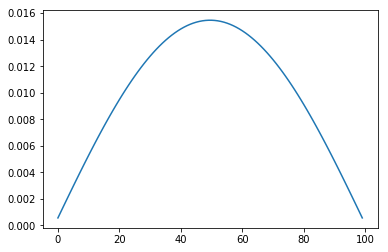

In [10]:
n_mesh = 100
k_new = 1.0
spacing = width/n_mesh
flux = np.ones(n_mesh)
norm = sum(flux)
flux = flux/norm
M,F = build_cmfd(n_mesh,spacing)
k_new, flux = solve_cmfd(n_mesh,flux,k_new)
plt.plot(flux)

In [11]:
M

array([[ 1.11904762, -0.33333333,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.33333333,  1.16666667, -0.33333333, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.33333333,  1.16666667, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.16666667,
        -0.33333333,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.33333333,
         1.16666667, -0.33333333],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.33333333,  1.11904762]])

In [12]:
k_new

1.1992275054071648